In [ ]:
# Autosave work every 60 seconds

import IPython
assert IPython.version_info[0] >= 3
%autosave 60

Autosaving every 60 seconds


## **Topic: Walmart Weekly Sales Forecast for Store 16**

# Table of Contents

* [1. Introduction and Company Overview](#1.-Introduction-and-Company-Overview)
* [2. Problem Statement and Question Framing](#2.-Problem-Statement-and-Question-Framing)
* [3. Data Overview](#3.-Data-Overview)
 * [3.1 Importing the Dataset](#3.1-Importing-the-Dataset)
 * [3.2 Initial Data Exploration](#3.2-Initial-Data-Exploration)
 * [3.3 Training and Testing Split](#3.3-Training-and-Testing-Split)
* [4. Data Visualisation](#4.-Data-Visualisation)
 * [4.1 Correlation Analysis](#4.1-Correlation-Analysis)
 * [4.2 Overall Weekly Sales](#4.2-Overall-Weekly-Sales)
 * [4.3 Sales per store](#4.3-Sales-per-store)
* [5. Data Preparation](#4.-Data-Preparation)
 * [5.1  Identifying Outliers](#5.1-Identifying-Outliers)
 * [5.2  Feature Scaling](#5.2-Feature-Scaling)
 * [5.3 Feature definition and Validation split](#5.3-Feature-definition-and-Validation-split)
* [6. Modelling](#6.-Modelling)
 * [6.1 Recurrent Neural Network (RNN)](#6.1-Recurrent-Neural-Network-(RNN))
 * [6.2 Convolutional Neural Network](#6.2-Convolutional-Neural-Network)
 * [6.3 LSTM (Long Short Term Memory)](#6.3-LSTM-(Long-Short-Term-Memory))
 * [6.4 CNN-LSTM](#6.4-CNN-LSTM)
 * [6.5 Model Comparisons](#6.5-Model-Comparisons)
* [7. Fine-Tuning](#7.-Fine-Tuning)
 * [7.1 Random Search](#7.1-Random-Search)
     * [7.1.1 RNN Random Search](#7.1.1-RNN-Random-Search)
     * [7.1.2 CNN Random Search](#7.1.2-CNN-Random-Search)
     * [7.1.3 CNN-LSTM Random Search](#7.1.3-CNN-LSTM-Random-Search)
 * [7.2 Ensemble method ](#7.2-Ensemble-method)          
* [8. Evaluation and Result](#8.-Evaluation-and-Result)
* [9. Conclusion and Limitations](#9.-Conclusion-and-Limitations)
* [10. Recommendations](#10.-Recommendations)
* [11. References](#11.-References)

**Importing necessary libraries and modules**

In [ ]:
!pip install tensorflow
!pip install --no-deps scikeras
!pip install nbconvert[webpdf]

zsh:1: no matches found: nbconvert[webpdf]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import Adam
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense


In [ ]:
# For reproduction purposes
random = 889
np.random.seed(random)

# 1. Introduction and Company Overview

Walmart is an American multinational retail company that specilizes in operates a chain of supermarkets and grocery stores. It currently operates about 10,500 stores and clubs in 20 different countries(1). This retail company was denoted the largest retailer in the world in 2021 based retail revenue(2). As a company in the food industry, it is essential to gain insights regarding expected future demand so as to avoid waste (perishable goods).

# 2. Problem Statement and Question Framing

Walmart, as a major retailer, needs to be able to predict sales correctly in order to successfully manage inventory levels, optimize staffing, and plan marketing campaigns. The aim of this project is to create a neural network-based predictive model capable of correctly forecasting weekly sales for one of Walmart's location using historical sales data from 2010 to 2012. This will enable Walmart to make data-driven decisions that will help reduce waste and costs, increase its profitability and manage overall effectiveness.

# 3. Data Overview

The dataset used for this analysis is a historical sales data of 45 Walmart stores. This is a weekly time series data that ranges from Febrauray 2010 to October 2012. It includes factors that could affect sales such as holiday occurence (binary), temperature, fuel price and unemployement rate.

### 3.1  Importing the Dataset

The dataset was obtained from Kaggle. It can be assessed through - https://www.kaggle.com/datasets/varsharam/walmart-sales-dataset-of-45stores

In [ ]:
df = pd.read_csv('Walmart_data.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
# converting the date to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

### 3.2 Initial Data Exploration

In [ ]:
# To gain insights about the columns attributes and characteristics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


The dataset seems to be very clean with no missing values and few discrepancies. From the above table, the Temperature column seems to be negatively skewed. Further visualization has to be done to ascertain with certainty.

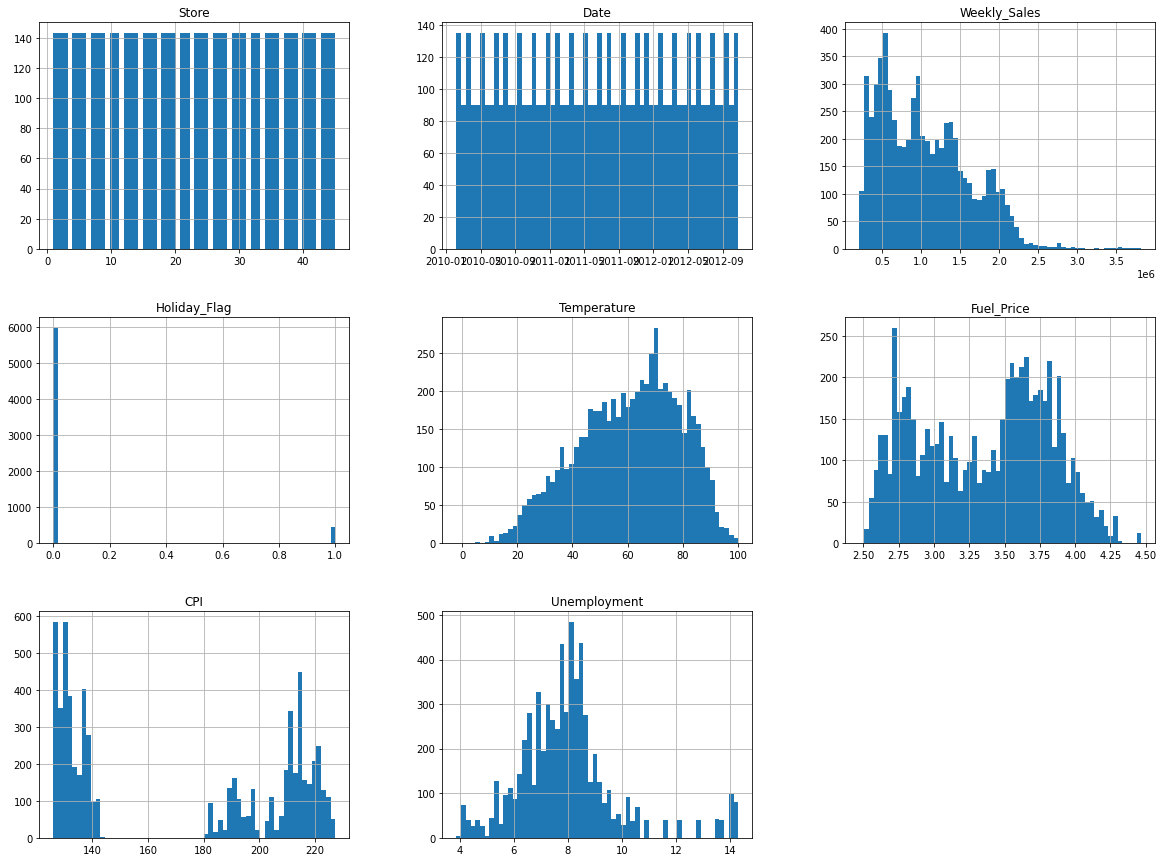

In [ ]:
df.hist(bins=60, figsize=(20,15))
plt.show()

The above histogram shows that all the stores have the same number of observations (143 each). The weekly sales plot reveal that majority of the weeks saw less than 1 million dollars in revenue. Another notable observation is the distance in the Holiday_flag plot. This shows that more than 90% of the observations did not have a holiday in them.

### 3.3 Training and Testing Split

Dividing the entire dataset into two parts - for training the model and testing its performance on new data. The test set is set to the last 8 weeks of sales for each store.


In [ ]:
# Grouping by store
store_group = df.groupby('Store')

# Lists to store the training and testing data sets
train_df = []
test_df = []

# Iterate through each store group
for _, group in store_group:
    # Extract last 2 months (8 weeks) of sales as test set
    test_data = group.tail(8)
    # drop the test set from group to get train set
    train_data = group.drop(test_data.index)
    # Add train and test sets to corresponding lists
    train_df.append(train_data)
    test_df.append(test_data)

# Combine train and test sets for all stores
train_df = pd.concat(train_df)
test_df = pd.concat(test_df)


In [ ]:
train_df
test_df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
135,1,2012-09-07,1661767.33,1,83.96,3.730,222.439015,6.908
136,1,2012-09-14,1517428.87,0,74.97,3.717,222.582019,6.908
137,1,2012-09-21,1506126.06,0,69.87,3.721,222.781839,6.908
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
print('Max date from train set: %s' % train_df['Date'].max().date())
print('Min date from test set: %s' % test_df['Date'].min().date())

Max date from train set: 2012-08-31
Min date from test set: 2012-09-07


## 4. Data Visualisation

In this section, the patterns and trends in the historical weekly sales dataset will be explored.

### 4.1 Correlation Analysis

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

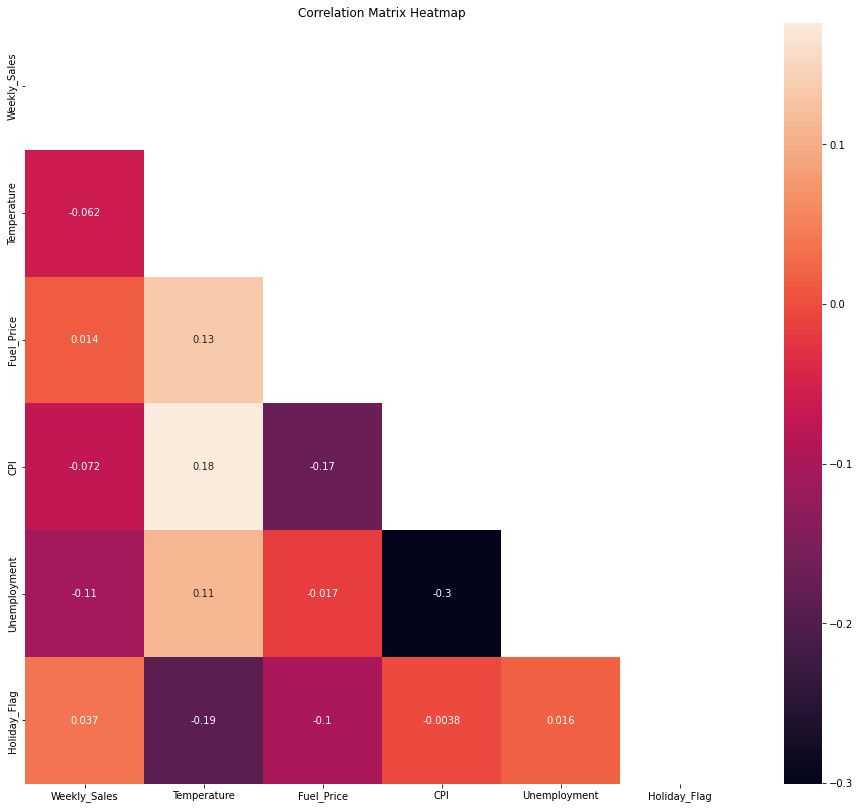

In [ ]:
corr_matrix = train_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Holiday_Flag']].corr()
fig, axs = plt.subplots(figsize=(16,14))

# Display only bottom half of diagram
half = np.zeros_like(corr_matrix)
half[np.triu_indices_from(half)] = True

# Correlation heatmap
sns.heatmap(corr_matrix, mask = half, annot=True)

axs.set_title('Correlation Matrix Heatmap')

From the diagram, Unemployment seems to have the strongest correlation with weekly_sales but will not be included in the model because it has a strong correlation with CPI. Temperature, CPI and Holiday_Flag would abe included in feature selection as they have a relatively significant relationship with sales.

### 4.2 Overall Weekly Sales

In [ ]:
# Grouping the total sales accross all stores by weeks
total_weekly_sales = train_df.groupby('Date', as_index=False)['Weekly_Sales'].sum()
total_weekly_sales

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
130,2012-08-03,47485899.56
131,2012-08-10,47403451.04
132,2012-08-17,47354452.05
133,2012-08-24,47447323.60


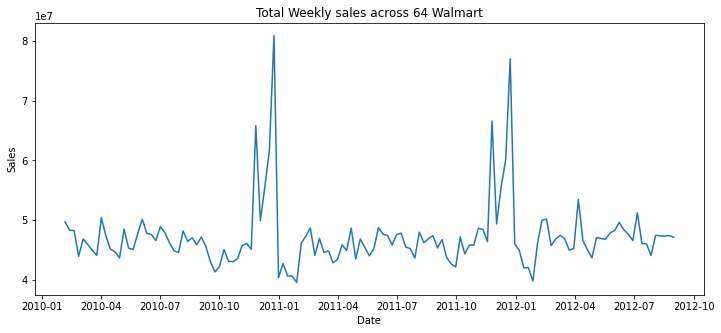

In [ ]:
# Plotting the weekly total sales diagram
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(total_weekly_sales['Date'], total_weekly_sales['Weekly_Sales'])
ax.set_title('Total Weekly sales across 64 Walmart')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()


Total weekly sales peaked in December 24, 2010 and December 23, 2011. This is probably due to increased spending during the holiday festive period. Based on this assumption, the occurence of holiday in a week does have an imact on the number of sales.

### 4.3 Sales per store

In [ ]:
# Grouping the weekly sales value by the stores
train_df['Month'] = train_df['Date'].dt.month
store_monthly_sales = train_df.groupby(['Store', 'Month'], as_index=False)['Weekly_Sales'].mean()
store_monthly_sales

,Store,Month,Weekly_Sales
0,1,1,1.400468e+06
1,1,2,1.625442e+06
2,1,3,1.567744e+06
3,1,4,1.544510e+06
4,1,5,1.542111e+06
...,...,...,...
535,45,8,7.361081e+05
536,45,9,7.226548e+05
537,45,10,7.380653e+05
538,45,11,8.778102e+05


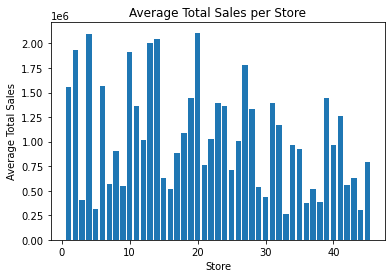

In [ ]:
# Calculate the average weekly sales for each store
avg_sales = train_df.groupby('Store')['Weekly_Sales'].mean()

# Plot the bar chart

# create a bar plot
fig, ax = plt.subplots()
ax.bar(avg_sales.index, avg_sales.values)

plt.xlabel('Store')
plt.ylabel('Average Total Sales')
plt.title('Average Total Sales per Store')
plt.show()


For more extensive analysis, this project will feature only store 16 in the modelling process.

## 5. Data Preparation

The next step is to employ transformation techniques to better expose the underlying data patterns to Machine Learning algorithms

In [ ]:
# Filter the data by store (only store 16 to enable more extensive analysis)
store_sales = train_df[train_df['Store'] == 16][['Date', 'Holiday_Flag', 'Temperature', 'CPI', 'Weekly_Sales']]
store_df = store_sales.set_index('Date')
store_df

,Holiday_Flag,Temperature,CPI,Weekly_Sales
Date,,,,
2010-02-05,0,19.79,189.381697,477409.30
2010-02-12,1,20.87,189.464272,472044.28
2010-02-19,0,21.13,189.534100,469868.70
2010-02-26,0,18.12,189.601802,443242.17
2010-03-05,0,27.92,189.669505,444181.85
...,...,...,...,...
2012-08-03,0,68.59,198.029389,584000.71
2012-08-10,0,70.24,198.079565,554036.84
2012-08-17,0,62.07,198.100106,521896.60


### 5.1 Identifying Outliers

<Axes: >

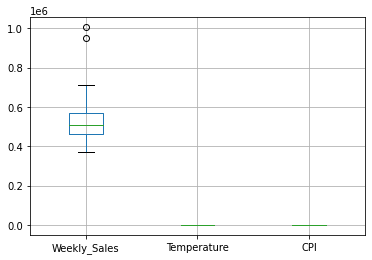

In [ ]:
# create a list of variables in the training dataset with numerical data type
numeric = ['Weekly_Sales','Temperature', 'CPI']

# plotting a boxplot on the numerical variables
store_df.boxplot(numeric)

Weekly_sales has a lot of outliers but they would not be removed beacuse they could signify the seasonal trends in the weekly sales dataset.

### 5.2 Feature Scaling

In [ ]:
# Utilizing Min- max to preserve the original distribution of the dataset
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(store_df)

# Create a DataFrame with scaled features and target variable
scaled_df = pd.DataFrame(scaled_features, columns=store_df.columns)
scaled_df

,Holiday_Flag,Temperature,CPI,Weekly_Sales
0,0.0,0.113986,0.000000,0.171049
1,1.0,0.130622,0.009471,0.162615
2,0.0,0.134627,0.017481,0.159195
3,0.0,0.088262,0.025246,0.117338
4,0.0,0.239217,0.033011,0.118815
...,...,...,...,...
130,0.0,0.865681,0.991889,0.338611
131,0.0,0.891097,0.997644,0.291507
132,0.0,0.765250,1.000000,0.240983
133,0.0,0.755545,0.999807,0.286973


### 5.3  Feature definition and Validation split

The target variable y (weekly sales) and the independent variables X (other relevant variables) that will be used to train the model are specified. Furthermore, the train set is split into two : Train set and validation set. Fuel_Price is not included in the model because it has a weak relationship with weekly sales.

In [ ]:
# Further division of the training set into train and val set
train_size = int(len(scaled_df) * 0.8)
val_size = len(scaled_df) - train_size
train_data = np.array(scaled_df.iloc[:train_size, :])
val_data = np.array(scaled_df.iloc[train_size:, :])

X_train, y_train = train_data[:], train_data[0:, -1]
X_val, y_val = val_data[:], val_data[0:, -1]

X_train
len(X_train)

108

## 6. Modelling

In this section, several neural network architectures will be trained on the train set and evaluated on the validation set. The models used in this analysis include CNN, RNN, LSTM and CNN-LSTM. The performance of the models are evaluated using Root mean squared error (RSME).

In [ ]:
# Reshaping the data to fit the format of RNN and CNN models
X_train_shape = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_shape = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

X_train.shape

(108, 4)

### 6.1 Recurrent Neural Network (RNN)

RNN is the most commonly used neural network architecture for time sequence prediction (3). For this sales forecasting problem, a deep (combination of recurrent layers) RNN model will be used to train the model.

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, return_sequences=True, input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(units=1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
rnn_history= model_rnn.fit(X_train_shape, y_train,
               epochs=40,
               validation_data=(X_val_shape, y_val)
              )



2023-03-25 21:34:11.820094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
4/4 [==============================] - 5s 232ms/step - loss: 0.0321 - val_loss: 0.0696
Epoch 2/40
4/4 [==============================] - 0s 24ms/step - loss: 0.0237 - val_loss: 0.0089
Epoch 3/40
4/4 [==============================] - 0s 25ms/step - loss: 0.0169 - val_loss: 0.0117
Epoch 4/40
4/4 [==============================] - 0s 19ms/step - loss: 0.0123 - val_loss: 0.0059
Epoch 5/40
4/4 [==============================] - 0s 24ms/step - loss: 0.0068 - val_loss: 0.0021
Epoch 6/40
4/4 [==============================] - 0s 27ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 7/40
4/4 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 8/40
4/4 [==============================] - 0s 25ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 9/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 4.8887e-04
Epoch 10/40
4/4 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 11/40
4/4 [=======

In [ ]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 64)             4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_train_pred = model_rnn.predict(X_train_shape)
rnn_val_pred = model_rnn.predict(X_val_shape)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, rnn_val_pred)))

1/1 [==============================] - 0s 33ms/step
Train rmse: 0.004646035123455071
Validation rmse: 0.02653461776355622


### 6.2 Convolutional Neural Network

In this analysis, CNN is explored as a means of identifying underlying patterns in the historical sales data of store 16. This model is known to be useful for identifying seasonal patterns and other trends and therefore beneficial for forecasting.

In [ ]:
# Defining the model with one dimentional convolutional layer
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')

# Train the model
cnn_history = model_cnn.fit(X_train_shape, y_train,
               epochs=40,
               validation_data=(X_val_shape, y_val)
              )


Epoch 1/40
4/4 [==============================] - 3s 147ms/step - loss: 0.1045 - val_loss: 0.0702
Epoch 2/40
4/4 [==============================] - 0s 33ms/step - loss: 0.0568 - val_loss: 0.0186
Epoch 3/40
4/4 [==============================] - 0s 21ms/step - loss: 0.0299 - val_loss: 0.0057
Epoch 4/40
4/4 [==============================] - 0s 17ms/step - loss: 0.0208 - val_loss: 0.0172
Epoch 5/40
4/4 [==============================] - 0s 24ms/step - loss: 0.0205 - val_loss: 0.0331
Epoch 6/40
4/4 [==============================] - 0s 25ms/step - loss: 0.0232 - val_loss: 0.0388
Epoch 7/40
4/4 [==============================] - 0s 69ms/step - loss: 0.0231 - val_loss: 0.0331
Epoch 8/40
4/4 [==============================] - 0s 17ms/step - loss: 0.0216 - val_loss: 0.0246
Epoch 9/40
4/4 [==============================] - 0s 18ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 10/40
4/4 [==============================] - 0s 43ms/step - loss: 0.0198 - val_loss: 0.0144
Epoch 11/40
4/4 [===========

In [ ]:
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
____________________________________________________

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_shape)
cnn_val_pred = model_cnn.predict(X_val_shape)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, cnn_val_pred)))

1/1 [==============================] - 0s 24ms/step
Train rmse: 0.13579829511303596
Validation rmse: 0.12446168793941502


### 6.3 LSTM (Long Short Term Memory)

The third model that is considered for this analysis is LSTM. This model is typically useful for sequence prediction tasks because it sees input data as a sequence. This matches with the goal of this analysis - to predict future weekly sales in store 16 based on the sequence of past sales.

In [ ]:
# Build the LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=128, activation='relu', input_shape=(None, 4)))
model_LSTM.add(Dense(units=64, activation='relu'))
model_LSTM.add(Dense(units=1))
model_LSTM.compile(optimizer='adam', loss='mse')

# Train the model
LSTM_history = model_LSTM.fit(X_train.reshape(-1, 1, 4), y_train,
               epochs=40,
               batch_size=32,
               validation_data=(X_val.reshape(-1, 1, 4), y_val)
              )


Epoch 1/40
4/4 [==============================] - 3s 128ms/step - loss: 0.0657 - val_loss: 0.0356
Epoch 2/40
4/4 [==============================] - 0s 24ms/step - loss: 0.0488 - val_loss: 0.0196
Epoch 3/40
4/4 [==============================] - 0s 23ms/step - loss: 0.0344 - val_loss: 0.0088
Epoch 4/40
4/4 [==============================] - 0s 26ms/step - loss: 0.0231 - val_loss: 0.0052
Epoch 5/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0170 - val_loss: 0.0100
Epoch 6/40
4/4 [==============================] - 0s 21ms/step - loss: 0.0170 - val_loss: 0.0180
Epoch 7/40
4/4 [==============================] - 0s 25ms/step - loss: 0.0183 - val_loss: 0.0194
Epoch 8/40
4/4 [==============================] - 0s 21ms/step - loss: 0.0171 - val_loss: 0.0142
Epoch 9/40
4/4 [==============================] - 0s 32ms/step - loss: 0.0153 - val_loss: 0.0096
Epoch 10/40
4/4 [==============================] - 0s 39ms/step - loss: 0.0140 - val_loss: 0.0071
Epoch 11/40
4/4 [===========

In [ ]:
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_train_pred = model_LSTM.predict(X_train.reshape(-1, 1, 4))
LSTM_val_pred = model_LSTM.predict(X_val.reshape(-1, 1, 4))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, LSTM_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, LSTM_val_pred)))

1/1 [==============================] - 0s 47ms/step
Train rmse: 0.0058447885623953795
Validation rmse: 0.0075464050835624


### 6.4 CNN-LSTM

This model combines the use of LSTM (variant of RNN) and 1D convolutional model. This model has the capacity to detect long-term dependencies in the data and is generally known to have a better performance.

In [ ]:
# Defining the model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(LSTM(64, return_sequences=True))
model_cnn_lstm.add(LSTM(32))
model_cnn_lstm.add(Dense(units=1))
model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and storing loss history
cnn_lstm_history = model_cnn_lstm.fit(X_train_shape, y_train,
               epochs=40,
               validation_data=(X_val_shape, y_val)
              )


Epoch 1/40
4/4 [==============================] - 11s 546ms/step - loss: 0.0743 - val_loss: 0.0539
Epoch 2/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0644 - val_loss: 0.0422
Epoch 3/40
4/4 [==============================] - 0s 27ms/step - loss: 0.0548 - val_loss: 0.0305
Epoch 4/40
4/4 [==============================] - 0s 37ms/step - loss: 0.0444 - val_loss: 0.0189
Epoch 5/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0338 - val_loss: 0.0094
Epoch 6/40
4/4 [==============================] - 0s 22ms/step - loss: 0.0251 - val_loss: 0.0058
Epoch 7/40
4/4 [==============================] - 0s 54ms/step - loss: 0.0199 - val_loss: 0.0118
Epoch 8/40
4/4 [==============================] - 0s 37ms/step - loss: 0.0201 - val_loss: 0.0188
Epoch 9/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0221 - val_loss: 0.0182
Epoch 10/40
4/4 [==============================] - 0s 32ms/step - loss: 0.0210 - val_loss: 0.0135
Epoch 11/40
4/4 [==========

In [ ]:
model_cnn_lstm.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 64)             192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 45,665
Trainable params: 45,665
Non-trainable params: 0
__________________________________________________

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_shape)
cnn_lstm_val_pred = model_cnn_lstm.predict(X_val_shape)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, cnn_lstm_val_pred)))

1/1 [==============================] - 0s 34ms/step
Train rmse: 0.1378599726692528
Validation rmse: 0.10758593864750898


Overall, RNN seems to have the lowest RMSE with 0.004 on the training set and 0.02 on the validation set.

### 6.5 Model Comparisons

Next, the models will be compared in terms of performance and training and validation loss.

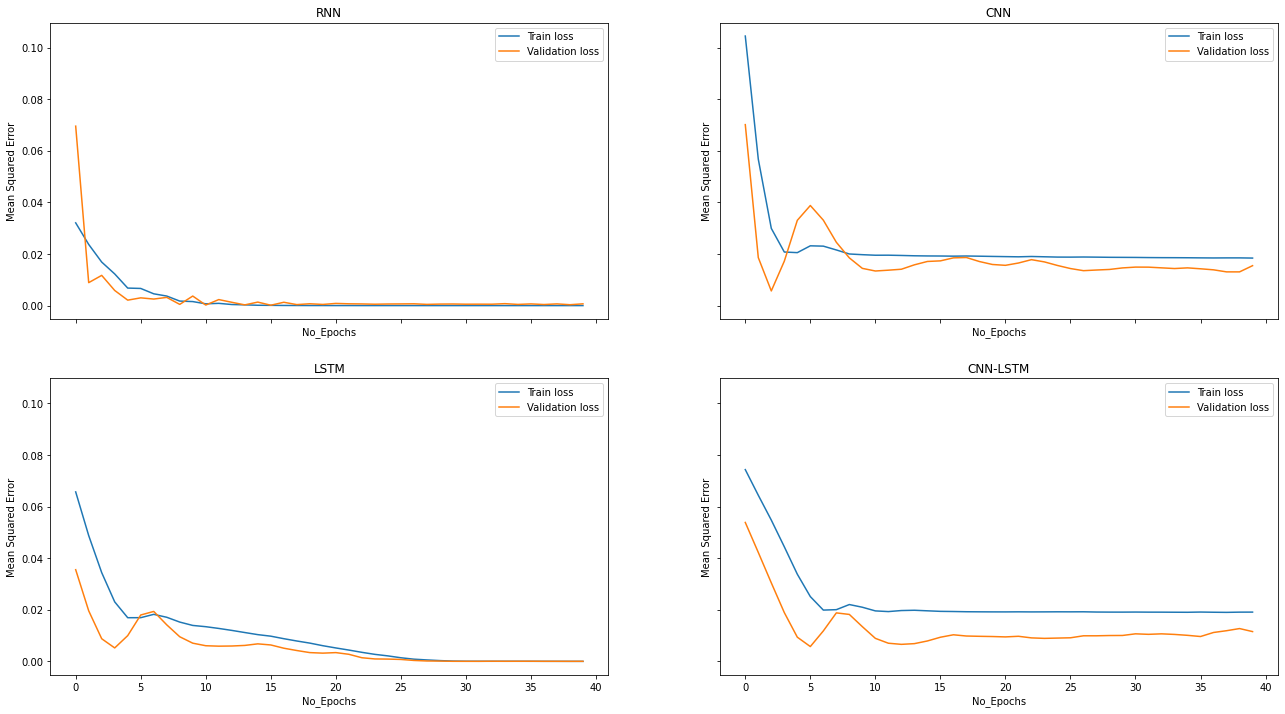

In [ ]:
# creating the subplots
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

# RNN - Loss function history
ax1.plot(rnn_history.history['loss'], label='Train loss')
ax1.plot(rnn_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('RNN')
ax1.set_xlabel('No_Epochs')
ax1.set_ylabel('Mean Squared Error')

# CNN - Loss function history
ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('No_Epochs')
ax2.set_ylabel('Mean Squared Error')

# LTSM - Loss function history
ax3.plot(LSTM_history.history['loss'], label='Train loss')
ax3.plot(LSTM_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('No_Epochs')
ax3.set_ylabel('Mean Squared Error')

# CNN-LTSM - Loss function history
ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('No_Epochs')
ax4.set_ylabel('Mean Squared Error')

plt.show()

From the results, RNN reached 0.00 MSE loss on both training and validation set at 10 epochs. After this point, the model seems to have plateaued and reached a straight line. Similar patterns can be observed in the other models too.

# 7. Fine-Tuning

To further improve performance, several techniques would be taken in this section. Random search will be performed for each of the model to identify the best hyperparameters to use and an ensemble model will be created.

## 7.1 Random Search

In this section, a random search will be conducted on each model to identify the optimal hyperparameters combination that generate the least error. To do so, we have to wrap each model in a keras regressor so that the model has the function random search needs.

### 7.1.1  RNN Random Search

In [ ]:
# Defining the parameter space
parameter_space = {
    'neurons': sp_randint(10, 100),
    'learning_rate': uniform(0.0001, 0.1),
    'epochs': [20, 30, 40]}

# the model function
def rnn(learning_rate = 0.01, neurons = 10):
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units=neurons, return_sequences=True, input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
    model_rnn.add(SimpleRNN(10))
    model_rnn.add(Dense(units=1))
    optimiser = Adam(learning_rate=learning_rate)
    model_rnn.compile(optimizer=optimiser, loss='mean_squared_error')
    return model_rnn

# Wraping the rnn model in a scikit-learn estimator (KerasRegressor)
rnn_wrap = KerasRegressor(build_fn=rnn)

# Creating a RandomSearchCV object
random_search = RandomizedSearchCV(rnn_wrap, param_distributions=parameter_space, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=123)
random_search.fit(X_train_shape, y_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/var/folders/tm/qv8g9h112v52mx8snqm4n83h0000gn/T/ipykernel_11783/325556796.py:18: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.

2023-03-25 21:49:20.274586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 21:49:20.355159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 21:49:20.375194: I tensorflow

Epoch 1/20
Epoch 1/40
Epoch 1/40
Epoch 1/40
3/3 [==============================] - 8s 12ms/step - loss: 2.2975
Epoch 2/20
3/3 [==============================] - 0s 8ms/step - loss: 0.1671
Epoch 3/40
3/3 [==============================] - 0s 26ms/step - loss: 0.0700
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0479
Epoch 4/20
3/3 [==============================] - 0s 54ms/step - loss: 0.0280
Epoch 4/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 5/20
3/3 [==============================] - 8s 65ms/step - loss: 3.3854
Epoch 2/40
3/3 [==============================] - 0s 40ms/step - loss: 0.6788
Epoch 3/40
3/3 [==============================] - 0s 15ms/step - loss: 2.5557
Epoch 3/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0691
Epoch 4/40
3/3 [==============================] - 0s 10ms/step - loss: 0.5197
Epoch 4/40
3/3 [==============================] - 0s 7ms/step - loss: 0.2490
Epoch 5/40
3/3 [===================

3/3 [==============================] - 0s 11ms/step - loss: 0.0290
Epoch 29/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 27/40
3/3 [==============================] - 0s 48ms/step - loss: 0.0205
Epoch 28/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0277
Epoch 30/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 28/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0279
Epoch 29/40
Epoch 31/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 30/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0277
Epoch 32/40
1/3 [=========>....................] - ETA: 0s - loss: 0.0342Epoch 31/40
Epoch 29/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0269
Epoch 33/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 32/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0200
Epoch 33/40
3/3 [==============================] - 0

3/3 [==============================] - 0s 10ms/step - loss: 0.0264
Epoch 21/40
3/3 [==============================] - 0s 22ms/step - loss: 0.0196
Epoch 14/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0271
Epoch 22/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0217
Epoch 23/40
Epoch 15/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0562
Epoch 8/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0272
Epoch 24/40
3/3 [==============================] - 0s 16ms/step - loss: 0.0448
Epoch 9/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0184
Epoch 10/40
Epoch 17/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0282
Epoch 11/40
Epoch 18/20
3/3 [==============================] - 0s 39ms/step - loss: 0.0274
Epoch 25/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0201
Epoch 12/40
Epoch 19/20
3/3 [==============================] - 0s 26ms/step - loss: 0.0267
Epoch 26/40
3/3 [====

3/3 [==============================] - 0s 27ms/step - loss: 0.0199
Epoch 23/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0273
Epoch 12/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0266
Epoch 13/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0198
Epoch 24/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0280
Epoch 14/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0195
Epoch 25/40
3/3 [==============================] - 0s 22ms/step - loss: 0.0269
Epoch 26/40
Epoch 15/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0277
Epoch 27/40
Epoch 16/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 28/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 17/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 18/30
Epoch 29/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0193
Epoch 30/40
3/3 [==================

2/2 [==============================] - 1s 4ms/step - loss: 0.0327
[CV] END epochs=30, learning_rate=0.06858297385848633, neurons=57; total time=   8.7s
Epoch 1/30
[CV] END epochs=30, learning_rate=0.06858297385848633, neurons=57; total time=   8.7s
Epoch 1/40
3/3 [==============================] - 5s 5ms/step - loss: 0.9735
Epoch 2/30
3/3 [==============================] - 0s 7ms/step - loss: 0.2534
Epoch 3/30
3/3 [==============================] - 5s 7ms/step - loss: 1.0722
Epoch 2/30
3/3 [==============================] - 0s 7ms/step - loss: 0.1346
Epoch 4/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0824
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0605
Epoch 5/30
3/3 [==============================] - 0s 11ms/step - loss: 0.1455
Epoch 4/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0418
Epoch 6/30
Epoch 5/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0347
Epoch 7/30
3/3 [=============================

3/3 [==============================] - 0s 8ms/step - loss: 0.0262
Epoch 9/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 10/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 11/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0095
Epoch 12/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 13/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 14/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 15/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 16/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 17/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0023
Epoch 18/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 19/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 20/40
3/3 [==============================] - 0s 6ms/step - loss: 0.001

Epoch 23/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0294
Epoch 6/20
3/3 [==============================] - 0s 7ms/step - loss: 1.7666e-04
Epoch 24/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0705
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 1.9347e-04
Epoch 25/40
3/3 [==============================] - 0s 7ms/step - loss: 3.5908e-04
Epoch 8/20
Epoch 34/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0260
Epoch 35/40
Epoch 9/20
3/3 [==============================] - 0s 11ms/step - loss: 1.7669e-04
Epoch 36/40
3/3 [==============================] - 0s 14ms/step - loss: 0.0399
Epoch 10/20
3/3 [==============================] - 0s 7ms/step - loss: 1.9573e-04
Epoch 37/40
3/3 [==============================] - 0s 7ms/step - loss: 1.7445e-04
Epoch 38/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0424
Epoch 26/40
Epoch 11/20
3/3 [==============================] - 0s 6ms/step - loss: 1.0961e-04


2/2 [==============================] - 1s 6ms/step - loss: 8.1896e-04


2/2 [==============================] - 1s 8ms/step - loss: 0.0103
[CV] END epochs=40, learning_rate=0.006067789660956836, neurons=90; total time=   8.4s
Epoch 1/20
[CV] END epochs=40, learning_rate=0.006067789660956836, neurons=90; total time=   8.3s
Epoch 1/40


2/2 [==============================] - 1s 9ms/step - loss: 0.0323
[CV] END epochs=20, learning_rate=0.06327920176870505, neurons=77; total time=   8.4s
Epoch 1/40
[CV] END epochs=20, learning_rate=0.06327920176870505, neurons=77; total time=   8.2s
Epoch 1/40
3/3 [==============================] - 5s 5ms/step - loss: 3.1267
Epoch 2/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 3/20
3/3 [==============================] - 0s 5ms/step - loss: 0.1711
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 0.1027
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0418
Epoch 6/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0415
Epoch 7/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0320
Epoch 8/20
3/3 [==============================] - 5s 8ms/step - loss: 0.9436
Epoch 2/40
3/3 [==============================] - 0s 9ms/step - loss: 0.1758
Epoch 3/40
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 8ms/step - loss: 4.5521e-04
Epoch 36/40
3/3 [==============================] - 0s 8ms/step - loss: 4.0611e-04
Epoch 37/40
3/3 [==============================] - 0s 6ms/step - loss: 4.1888e-04
Epoch 38/40
3/3 [==============================] - 0s 8ms/step - loss: 3.5616e-04
Epoch 39/40
3/3 [==============================] - 0s 7ms/step - loss: 4.0049e-04
Epoch 40/40
3/3 [==============================] - 6s 12ms/step - loss: 0.3108
Epoch 2/40
3/3 [==============================] - 0s 7ms/step - loss: 0.1084
Epoch 3/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0688
Epoch 4/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0682
Epoch 5/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0286
Epoch 6/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 7/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0240
Epoch 8/40
3/3 [==============================] - 0s 8ms/step

2/2 [==============================] - 2s 8ms/step - loss: 4.7998e-04
[CV] END epochs=20, learning_rate=0.06327920176870505, neurons=77; total time=   9.1s
Epoch 1/20
2/2 [==============================] - 1s 6ms/step - loss: 2.1436e-04


2/2 [==============================] - 1s 5ms/step - loss: 0.0024
[CV] END epochs=40, learning_rate=0.008472648456358433, neurons=76; total time=   9.4s
Epoch 1/20
[CV] END epochs=40, learning_rate=0.008472648456358433, neurons=76; total time=  10.0s
Epoch 1/20
[CV] END epochs=40, learning_rate=0.008472648456358433, neurons=76; total time=   9.6s
Epoch 1/20
3/3 [==============================] - 5s 6ms/step - loss: 1.4314
Epoch 2/20
3/3 [==============================] - 0s 7ms/step - loss: 1.0592
Epoch 3/20
3/3 [==============================] - 0s 6ms/step - loss: 0.2627
Epoch 4/20
3/3 [==============================] - 0s 5ms/step - loss: 0.1136
Epoch 5/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 6/20
3/3 [==============================] - 0s 5ms/step - loss: 0.1307
Epoch 7/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0667
Epoch 8/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 9/20
3/3 [===================

Epoch 20/20
3/3 [==============================] - 3s 4ms/step - loss: 1.9773
Epoch 2/20
3/3 [==============================] - 0s 4ms/step - loss: 0.7606
Epoch 3/20
3/3 [==============================] - 0s 4ms/step - loss: 0.1733
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0197
Epoch 6/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 7/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 8/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 9/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0187
Epoch 10/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 11/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0191
Epoch 12/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0196
Epoch 13/20
3/3 [==============================] - 0s 7ms/step - loss: 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fea44cad880>,
                   n_jobs=-1,
                   param_distributions={'epochs': [20, 30, 40],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fea552d8700>,
                                        'neurons': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fea48c30d90>},
                   random_state=123, verbose=2)

In [ ]:
# Print the best hyperparameters
print("Best RNN hyperparameters: ", random_search.best_params_)

Best RNN hyperparameters:  {'epochs': 40, 'learning_rate': 0.006067789660956836, 'neurons': 90}


In [ ]:
# Applying the optimised hyperparameter to the model
model_rnn2 = Sequential()
model_rnn2.add(SimpleRNN(units=90, return_sequences=True, input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
model_rnn2.add(SimpleRNN(10))
model_rnn2.add(Dense(units=1))
optimiser = Adam(learning_rate=0.006067789660956836)
model_rnn2.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
rnn_history= model_rnn2.fit(X_train_shape, y_train,
               epochs=40,
               validation_data=(X_val_shape, y_val)
              )


Epoch 1/40
4/4 [==============================] - 3s 157ms/step - loss: 0.0417 - val_loss: 0.0097
Epoch 2/40
4/4 [==============================] - 0s 24ms/step - loss: 0.0461 - val_loss: 0.0121
Epoch 3/40
4/4 [==============================] - 0s 24ms/step - loss: 0.0299 - val_loss: 0.0290
Epoch 4/40
4/4 [==============================] - 0s 20ms/step - loss: 0.0247 - val_loss: 0.0090
Epoch 5/40
4/4 [==============================] - 0s 21ms/step - loss: 0.0239 - val_loss: 0.0062
Epoch 6/40
4/4 [==============================] - 0s 27ms/step - loss: 0.0158 - val_loss: 0.0116
Epoch 7/40
4/4 [==============================] - 0s 22ms/step - loss: 0.0133 - val_loss: 0.0049
Epoch 8/40
4/4 [==============================] - 0s 32ms/step - loss: 0.0112 - val_loss: 0.0059
Epoch 9/40
4/4 [==============================] - 0s 20ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 10/40
4/4 [==============================] - 0s 25ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 11/40
4/4 [===========

In [ ]:
# RMSE
rnn_train_pred2 = model_rnn2.predict(X_train_shape)
rnn_val_pred2 = model_rnn2.predict(X_val_shape)
print('Train rmse for the optimised RNN model:', np.sqrt(mean_squared_error(y_train, rnn_train_pred2)))
print('Validation rmse for the optimised RNN model:', np.sqrt(mean_squared_error(y_val, rnn_val_pred2)))

1/1 [==============================] - 0s 63ms/step
Train rmse for the optimised RNN model: 0.005544924809682892
Validation rmse for the optimised RNN model: 0.014044314885753173


### 7.1.2  CNN Random Search

In [ ]:
#Defining the parameter space
parameter_space = {
    'filters' : [64, 128, 192],
    'activation': ['relu', 'tanh'],
    'learning_rate' : uniform(0.0001, 0.1),
    'epochs': [20, 30, 40]}

# the model function
def cnn(filters = 64, kernel_size = 2, pool_size = 2, activation='relu', learning_rate=0.01):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=pool_size))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(64, activation=activation))
    model_cnn.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model_cnn.compile(optimizer=optimizer, loss='mean_squared_error')
    return model_cnn


# Wraping the rnn model in a scikit-learn estimator (KerasRegressor)
cnn_wrap = KerasRegressor(build_fn=cnn)

# Perform a randomized search over the hyperparameter space
random_search_cnn = RandomizedSearchCV(estimator=cnn_wrap, param_distributions=parameter_space, n_iter=10, cv=3,error_score='raise',random_state=123)
random_search_cnn.fit(X_train_shape, y_train)


/var/folders/tm/qv8g9h112v52mx8snqm4n83h0000gn/T/ipykernel_11783/1679422897.py:22: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Epoch 1/30
3/3 [==============================] - 1s 6ms/step - loss: 0.8904
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 0.1320
Epoch 3/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0776
Epoch 4/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0323
Epoch 5/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0423
Epoch 6/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch 7/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0294
Epoch 8/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0299
Epoch 9/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0276
Epoch 10/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0266
Epoch 11/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0273
Epoch 12/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 13/30
3/3 [==============================] - 0s 7ms/step - lo

3/3 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 14/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0320
Epoch 15/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 16/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0288
Epoch 17/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 18/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0260
Epoch 19/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0295
Epoch 20/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0262
Epoch 21/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0296
Epoch 22/40
3/3 [==============================] - 0s 8ms/step - loss: 0.0275
Epoch 23/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0279
Epoch 24/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0282
Epoch 25/40
3/3 [==============================] - 0s 6ms/step - loss: 0.

3/3 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 19/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 20/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 21/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 22/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 23/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0196
Epoch 24/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 25/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0195
Epoch 26/40
3/3 [==============================] - 0s 17ms/step - loss: 0.0197
Epoch 27/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 28/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 29/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 30/40
3/3 [==============================] - 0s 7ms/step - loss: 0.

3/3 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 21/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 22/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0197
Epoch 23/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 24/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0195
Epoch 25/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0169
Epoch 26/30
3/3 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 27/30
3/3 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 28/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 29/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 30/30
2/2 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 1/40
3/3 [==============================] - 1s 5ms/step - loss: 4.9070
Epoch 2/40
3/3 [==============================] - 0s 6ms/step - loss: 1.0459


3/3 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 13/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 14/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0289
Epoch 15/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0229
Epoch 16/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 17/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 18/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 19/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 20/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 21/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 22/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 23/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 24/40
3/3 [==============================] - 0s 7ms/step - loss: 0.01

3/3 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 15/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 16/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 17/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0181
Epoch 18/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 19/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0198
Epoch 20/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 21/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0177
Epoch 22/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0178
Epoch 23/30
3/3 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 24/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0176
Epoch 25/30
3/3 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 26/30
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 6ms/step - loss: 0.0264
Epoch 27/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 28/40
3/3 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 29/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0247
Epoch 30/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 31/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0248
Epoch 32/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 33/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0242
Epoch 34/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0241
Epoch 35/40
3/3 [==============================] - 0s 5ms/step - loss: 0.0240
Epoch 36/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0238
Epoch 37/40
3/3 [==============================] - 0s 6ms/step - loss: 0.0238
Epoch 38/40
3/3 [==============================] - 0s 7ms/step - loss: 0.0

3/3 [==============================] - 0s 10ms/step - loss: 0.0401
Epoch 9/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 10/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 11/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 12/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 13/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0309
Epoch 14/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 15/20
3/3 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 16/20
3/3 [==============================] - 0s 4ms/step - loss: 0.0275
Epoch 17/20
3/3 [==============================] - 0s 7ms/step - loss: 0.0273
Epoch 18/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0266
Epoch 19/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.01

3/3 [==============================] - 0s 4ms/step - loss: 0.0402
Epoch 10/20
3/3 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 11/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0902
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0257
Epoch 13/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0333
Epoch 14/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0488
Epoch 15/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0285
Epoch 16/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 17/20
3/3 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 18/20
3/3 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 19/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0200
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 1/30
3/3 [==============================] - 1s 4ms/step - loss: 8.6162

4/4 [==============================] - 1s 3ms/step - loss: 0.6264
Epoch 2/20
4/4 [==============================] - 0s 5ms/step - loss: 0.0620
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 0.0663
Epoch 4/20
4/4 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 5/20
4/4 [==============================] - 0s 7ms/step - loss: 0.0279
Epoch 6/20
4/4 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.0252
Epoch 8/20
4/4 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 9/20
4/4 [==============================] - 0s 10ms/step - loss: 0.0241
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.0239
Epoch 11/20
4/4 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 12/20
4/4 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 13/20
4/4 [==============================] - 0s 9ms/step - loss: 0.0225
Epoch

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fea5e2d7940>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'epochs': [20, 30, 40],
                                        'filters': [64, 128, 192],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fea551d5a60>},
                   random_state=123)

In [ ]:
# The best hyperparameters and the corresponding score
print("Best parameters: ", random_search_cnn.best_params_)

Best parameters:  {'activation': 'relu', 'epochs': 20, 'filters': 64, 'learning_rate': 0.06327920176870505}


In [ ]:
# Applying the optimised hyperparameter to the model

model_cnn2 = Sequential()
model_cnn2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
model_cnn2.add(MaxPooling1D(pool_size=2))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(50, activation='relu'))
model_cnn2.add(Dense(1))
optimizer = Adam(learning_rate=0.06327920176870505)
model_cnn2.compile(loss='mse', optimizer=optimizer)

# Train the model
cnn_history = model_cnn2.fit(X_train_shape, y_train,
               epochs=20,
               validation_data=(X_val_shape, y_val)
              )


Epoch 1/20
4/4 [==============================] - 1s 89ms/step - loss: 0.5968 - val_loss: 0.1004
Epoch 2/20
4/4 [==============================] - 0s 18ms/step - loss: 0.1021 - val_loss: 0.0740
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 0.0754 - val_loss: 0.0410
Epoch 4/20
4/4 [==============================] - 0s 18ms/step - loss: 0.0437 - val_loss: 0.0152
Epoch 5/20
4/4 [==============================] - 0s 21ms/step - loss: 0.0250 - val_loss: 0.0079
Epoch 6/20
4/4 [==============================] - 0s 17ms/step - loss: 0.0222 - val_loss: 0.0111
Epoch 7/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0265 - val_loss: 0.0140
Epoch 8/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0284 - val_loss: 0.0128
Epoch 9/20
4/4 [==============================] - 0s 21ms/step - loss: 0.0259 - val_loss: 0.0094
Epoch 10/20
4/4 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0079
Epoch 11/20
4/4 [============

In [ ]:
# RMSE
cnn_train_pred2 = model_cnn2.predict(X_train_shape)
cnn_val_pred2 = model_cnn2.predict(X_val_shape)
print('Train rmse for optimised CNN model:', np.sqrt(mean_squared_error(y_train, cnn_train_pred2)))
print('Validation rmse for optimised CNN model:', np.sqrt(mean_squared_error(y_val, cnn_val_pred2)))

1/1 [==============================] - 0s 35ms/step
Train rmse for optimised CNN model: 0.14719742021600946
Validation rmse for optimised CNN model: 0.08894310094517642


### 7.1.3  CNN-LSTM Random Search

In [ ]:
# defining the hyperparameter values
parameter_space = {
    'filters': [64, 128, 256],
    'activation': ['relu', 'tanh'],
    'learning_rate' : uniform(0.0001, 0.1),
    'epochs': [20, 30, 40]
}

#defining the cnn_lstm model
def cnn_lstm(filters = 64, kernel_size = 2, pool_size = 2, activation='relu', learning_rate=0.01):
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
    model_cnn_lstm.add(MaxPooling1D(pool_size=pool_size))
    model_cnn_lstm.add(LSTM(64, return_sequences=True))
    model_cnn_lstm.add(LSTM(32))
    model_cnn_lstm.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model_cnn_lstm.compile(optimizer=optimizer, loss='mean_squared_error')
    return model_cnn_lstm


# Wraping the cnn_lstm model in a scikit-learn estimator (KerasRegressor)
cnn_lstm_wrap = KerasRegressor(build_fn=cnn_lstm)

# Performing a randomized search over the hyperparameter space
random_search_cnn_lstm = RandomizedSearchCV(estimator=cnn_lstm_wrap, param_distributions=parameter_space, n_iter=10, cv=3,error_score='raise', random_state=123)
random_search_cnn_lstm.fit(X_train_shape.reshape(-1, X_train_shape.shape[1], X_train_shape.shape[2]), y_train)





/var/folders/tm/qv8g9h112v52mx8snqm4n83h0000gn/T/ipykernel_11783/3943453155.py:23: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Epoch 1/30
3/3 [==============================] - 9s 7ms/step - loss: 0.0826
Epoch 2/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0318
Epoch 3/30
3/3 [==============================] - 0s 14ms/step - loss: 0.0280
Epoch 4/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0258
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 6/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0264
Epoch 7/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0300
Epoch 8/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0355
Epoch 9/30
3/3 [==============================] - 0s 7ms/step - loss: 0.0304
Epoch 10/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0269
Epoch 11/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0290
Epoch 12/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0275
Epoch 13/30
3/3 [==============================] - 0s 13ms/step -

Epoch 13/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0318
Epoch 14/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0275
Epoch 15/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 16/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0270
Epoch 17/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 18/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0267
Epoch 19/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 20/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0268
Epoch 21/40
3/3 [==============================] - 0s 14ms/step - loss: 0.0265
Epoch 22/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0266
Epoch 23/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0272
Epoch 24/40
3/3 [==============================] - 0s 18ms/step - loss: 0.0269
Epoch 25/40
3/3 [==============================] - 0s 8ms

3/3 [==============================] - 0s 15ms/step - loss: 0.0197
Epoch 36/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0198
Epoch 37/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0195
Epoch 38/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 39/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0203
Epoch 40/40
2/2 [==============================] - 2s 6ms/step - loss: 0.0279
Epoch 1/30
3/3 [==============================] - 12s 8ms/step - loss: 0.0861
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0524
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0369
Epoch 4/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0266
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 6/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0273
Epoch 7/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0

3/3 [==============================] - 0s 17ms/step - loss: 0.0267
Epoch 7/40
3/3 [==============================] - 0s 32ms/step - loss: 0.0269
Epoch 8/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0269
Epoch 9/40
3/3 [==============================] - 0s 14ms/step - loss: 0.0265
Epoch 10/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0267
Epoch 11/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0265
Epoch 12/40
3/3 [==============================] - 0s 18ms/step - loss: 0.0263
Epoch 13/40
3/3 [==============================] - 0s 25ms/step - loss: 0.0261
Epoch 14/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0255
Epoch 15/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0253
Epoch 16/40
3/3 [==============================] - 0s 14ms/step - loss: 0.0258
Epoch 17/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0243
Epoch 18/40
3/3 [==============================] - 0s 10ms/step - l

3/3 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 30/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 31/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0197
Epoch 32/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0195
Epoch 33/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0204
Epoch 34/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 35/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0198
Epoch 36/40
3/3 [==============================] - 0s 17ms/step - loss: 0.0195
Epoch 37/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0202
Epoch 38/40
3/3 [==============================] - 0s 13ms/step - loss: 0.0202
Epoch 39/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0196
Epoch 40/40
2/2 [==============================] - 1s 5ms/step - loss: 0.0316
Epoch 1/30
3/3 [==============================] - 6s 11ms/step - lo

2/2 [==============================] - 2s 6ms/step - loss: 0.0269
Epoch 1/20
3/3 [==============================] - 5s 14ms/step - loss: 0.1053
Epoch 2/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0524
Epoch 3/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0272
Epoch 4/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0264
Epoch 5/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0293
Epoch 6/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0332
Epoch 7/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0347
Epoch 8/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0301
Epoch 9/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0276
Epoch 10/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0287
Epoch 11/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0311
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.02

2/2 [==============================] - 1s 5ms/step - loss: 0.0127
Epoch 1/40
[CV] END epochs=20, learning_rate=0.04288634908378196, neurons=71; total time=  14.7s
3/3 [==============================] - 6s 8ms/step - loss: 0.0714
Epoch 2/40
3/3 [==============================] - 0s 16ms/step - loss: 0.0195
Epoch 3/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0293
Epoch 4/40
3/3 [==============================] - 0s 12ms/step - loss: 0.0174
[CV] END epochs=20, learning_rate=0.049308477679234235, neurons=62; total time=  14.8s
Epoch 5/40
3/3 [==============================] - 0s 18ms/step - loss: 0.0233
Epoch 6/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 7/40
3/3 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 8/40
3/3 [==============================] - 0s 11ms/step - loss: 0.0176
Epoch 9/40
3/3 [==============================] - 0s 9ms/step - loss: 0.0182
Epoch 10/40
3/3 [==============================] - 0s 7ms/ste

3/3 [==============================] - 0s 9ms/step - loss: 0.0266
Epoch 19/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0273
Epoch 20/20
2/2 [==============================] - 1s 7ms/step - loss: 0.0125
Epoch 1/20
3/3 [==============================] - 7s 11ms/step - loss: 0.1037
Epoch 2/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0365
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0355
Epoch 4/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0182
Epoch 5/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0182
Epoch 6/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0176
Epoch 7/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0176
Epoch 8/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0177
Epoch 9/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0177
Epoch 10/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0

3/3 [==============================] - 0s 14ms/step - loss: 0.0199
Epoch 19/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0219
Epoch 20/20
2/2 [==============================] - 2s 7ms/step - loss: 0.0299
Epoch 1/30
3/3 [==============================] - 6s 9ms/step - loss: 0.0860
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0320
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0319
Epoch 4/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0392
Epoch 5/30
3/3 [==============================] - 0s 11ms/step - loss: 0.0272
Epoch 6/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0285
Epoch 7/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 8/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0267
Epoch 9/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0266
Epoch 10/30
3/3 [==============================] - 0s 10ms/step - loss: 0.02

4/4 [==============================] - 0s 13ms/step - loss: 0.0211
Epoch 10/40
4/4 [==============================] - 0s 11ms/step - loss: 0.0207
Epoch 11/40
4/4 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 12/40
4/4 [==============================] - 0s 11ms/step - loss: 0.0202
Epoch 13/40
4/4 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 14/40
4/4 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 15/40
4/4 [==============================] - 0s 12ms/step - loss: 0.0210
Epoch 16/40
4/4 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 17/40
4/4 [==============================] - 0s 9ms/step - loss: 0.0203
Epoch 18/40
4/4 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 19/40
4/4 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 20/40
4/4 [==============================] - 0s 9ms/step - loss: 0.0205
Epoch 21/40
4/4 [==============================] - 0s 10ms/step - lo

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fea5d26d8e0>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'epochs': [20, 30, 40],
                                        'filters': [64, 128, 256],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fea452cc760>},
                   random_state=123)

In [ ]:
# Print the best hyperparameters and the corresponding score
print("Best parameters: ", random_search_cnn_lstm.best_params_)


Best parameters:  {'activation': 'tanh', 'epochs': 40, 'filters': 64, 'learning_rate': 0.053255137384183845}


In [ ]:
# Applying the optimised hyperparameter to the model

model_cnn_lstm2 = Sequential()
model_cnn_lstm2.add(Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_train_shape.shape[1], X_train_shape.shape[2])))
model_cnn_lstm2.add(MaxPooling1D(pool_size=2))
model_cnn_lstm2.add(LSTM(64, return_sequences=True))
model_cnn_lstm2.add(LSTM(32))
model_cnn_lstm2.add(Dense(units=1))
optimizer = Adam(learning_rate=0.053255137384183845)
model_cnn_lstm2.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model and storing loss history
cnn_lstm_history = model_cnn_lstm2.fit(X_train_shape, y_train,
               epochs=40,
               validation_data=(X_val_shape, y_val)
              )

Epoch 1/40
4/4 [==============================] - 7s 458ms/step - loss: 0.1287 - val_loss: 0.0123
Epoch 2/40
4/4 [==============================] - 0s 20ms/step - loss: 0.0302 - val_loss: 0.0074
Epoch 3/40
4/4 [==============================] - 0s 18ms/step - loss: 0.0213 - val_loss: 0.0139
Epoch 4/40
4/4 [==============================] - 0s 21ms/step - loss: 0.0238 - val_loss: 0.0098
Epoch 5/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0227 - val_loss: 0.0089
Epoch 6/40
4/4 [==============================] - 0s 37ms/step - loss: 0.0217 - val_loss: 0.0092
Epoch 7/40
4/4 [==============================] - 0s 26ms/step - loss: 0.0233 - val_loss: 0.0078
Epoch 8/40
4/4 [==============================] - 0s 56ms/step - loss: 0.0218 - val_loss: 0.0078
Epoch 9/40
4/4 [==============================] - 0s 31ms/step - loss: 0.0217 - val_loss: 0.0076
Epoch 10/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0219 - val_loss: 0.0080
Epoch 11/40
4/4 [===========

In [ ]:
# RMSE
cnn_lstm_train_pred2 = model_cnn_lstm2.predict(X_train_shape)
cnn_lstm_val_pred2 = model_cnn_lstm2.predict(X_val_shape)
print('Train rmse for optimised CNN-LSTM model:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred2)))
print('Validation rmse for optimised CNN-LSTM model:', np.sqrt(mean_squared_error(y_val, cnn_lstm_val_pred2)))

1/1 [==============================] - 0s 42ms/step
Train rmse for optimised CNN-LSTM model: 0.14778291666728488
Validation rmse for optimised CNN-LSTM model: 0.09082274654701047


## 7.2 Ensemble method

In this section, the various models trained will be collated together to form one poweful ensemble model.

In [ ]:
# The model input is defined and passed into each model's function
input_shape = X_train_shape.shape[1:]
model_input = Input(shape=input_shape)

model_1 = rnn()
model_2 = cnn()
model_3 = cnn_lstm()

output_1 = model_1(model_input)
output_2 = model_2(model_input)
output_3 = model_3(model_input)

# The output of each model is combined to gether and passed through a dense layer
merged_output = concatenate([output_1, output_2, output_3])
ensemble_output = Dense(1)(merged_output)

ensemble = Model(inputs=model_input, outputs=ensemble_output)
ensemble.compile(loss='mse', optimizer='adam')

# Finally the combined model is fit on the training and validation set with 40 epochs
ensemble.fit(X_train_shape, y_train, epochs=40, validation_data=(X_val_shape, y_val))


Epoch 1/40
4/4 [==============================] - 12s 600ms/step - loss: 0.0720 - val_loss: 0.0141
Epoch 2/40
4/4 [==============================] - 0s 52ms/step - loss: 0.0435 - val_loss: 0.0522
Epoch 3/40
4/4 [==============================] - 0s 37ms/step - loss: 0.0399 - val_loss: 0.0342
Epoch 4/40
4/4 [==============================] - 0s 23ms/step - loss: 0.0293 - val_loss: 0.0179
Epoch 5/40
4/4 [==============================] - 0s 29ms/step - loss: 0.0279 - val_loss: 0.0160
Epoch 6/40
4/4 [==============================] - 0s 28ms/step - loss: 0.0254 - val_loss: 0.0292
Epoch 7/40
4/4 [==============================] - 0s 29ms/step - loss: 0.0242 - val_loss: 0.0446
Epoch 8/40
4/4 [==============================] - 0s 45ms/step - loss: 0.0229 - val_loss: 0.0340
Epoch 9/40
4/4 [==============================] - 0s 30ms/step - loss: 0.0214 - val_loss: 0.0250
Epoch 10/40
4/4 [==============================] - 0s 30ms/step - loss: 0.0202 - val_loss: 0.0264
Epoch 11/40
4/4 [==========

In [ ]:
ensemble_train_pred = ensemble.predict(X_train_shape)
ensemble_val_pred = ensemble.predict(X_val_shape)
print('Train rmse for the ensemble model:', np.sqrt(mean_squared_error(y_train, ensemble_train_pred)))
print('Validation rmse for the ensemble model:', np.sqrt(mean_squared_error(y_val, ensemble_val_pred)))

1/1 [==============================] - 0s 29ms/step
Train rmse for the ensemble model: 0.051734799699353406
Validation rmse for the ensemble model: 0.08736437802620849


Overall, the RNN optimised model had the least root mean squared error of all the models ran.

# 8. Evaluation and Result

In this section, the best model (RNN optimised) will be employed on the dataset left out (test set) to ensure its ability to efficiently generalize.

In [ ]:
# Preparing the test set (data preparation steps)

# Filter the data by store
store_sales_test = test_df[test_df['Store'] == 16][['Date', 'Holiday_Flag', 'Temperature', 'CPI', 'Weekly_Sales']]
store_df_test = store_sales_test.set_index('Date')
store_df_test

,Holiday_Flag,Temperature,CPI,Weekly_Sales
Date,,,,
2012-09-07,1,60.09,198.095048,537138.58
2012-09-14,0,56.69,198.126718,526525.16
2012-09-21,0,56.48,198.358523,509942.56
2012-09-28,0,51.40,198.590328,469607.73
2012-10-05,0,50.46,198.822132,471281.68
2012-10-12,0,43.26,199.053937,491817.19
2012-10-19,0,40.59,199.148196,577198.97
2012-10-26,0,40.99,199.219532,475770.14


In [ ]:
scaled_features_test = scaler.fit_transform(store_df_test)

# Create a DataFrame with scaled features and target variable
scaled_test = pd.DataFrame(scaled_features_test, columns=store_df.columns)
scaled_test

,Holiday_Flag,Temperature,CPI,Weekly_Sales
0,1.0,1.000000,0.000000,0.627661
1,0.0,0.825641,0.028164,0.529015
2,0.0,0.814872,0.234307,0.374890
3,0.0,0.554359,0.440450,0.000000
4,0.0,0.506154,0.646594,0.015558
5,0.0,0.136923,0.852737,0.206424
6,0.0,0.000000,0.936562,1.000000
7,0.0,0.020513,1.000000,0.057276


In [ ]:
# defining x and y for test set
test_data = np.array(scaled_test)
X_test, y_test = test_data[:], test_data[0:, -1]

# Reshaping to fit RNN model
X_test_shape = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# predicting the test set values and comparing with actual values to rmse
rnn_test_pred = model_rnn2.predict(X_test_shape)
print('Test rmse on optimised RNN:', np.sqrt(mean_squared_error(y_test, rnn_test_pred)))

1/1 [==============================] - 0s 77ms/step
Test rmse on optimised RNN: 0.022529715976076097


The mean squared error of the weekly sales values predicted by this optimised rnn model is very low. This shows that this model is capable of making accurate predictions when introduced to new data.

In [ ]:
sales_df = pd.DataFrame({'Pred_sales': rnn_test_pred.T[0], 'Actual_sales': y_test}, index=store_sales_test['Date'])
sales_df

,Pred_sales,Actual_sales
Date,,
2012-09-07,0.575118,0.627661
2012-09-14,0.533910,0.529015
2012-09-21,0.381406,0.374890
2012-09-28,-0.001324,0.000000
2012-10-05,0.014683,0.015558
2012-10-12,0.207582,0.206424
2012-10-19,0.964934,1.000000
2012-10-26,0.057089,0.057276


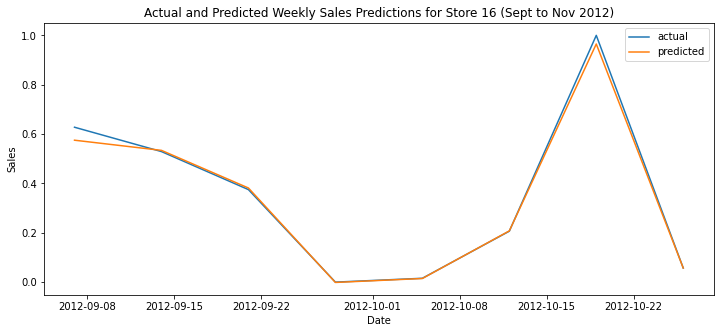

In [ ]:
# Diagram to show the difference between the predicted and actual values
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(sales_df.index, sales_df['Actual_sales'], label='actual')
ax.plot(sales_df.index, sales_df['Pred_sales'], label='predicted')
ax.legend()

ax.set_title("Actual and Predicted Weekly Sales Predictions for Store 16 (Sept to Nov 2012)")
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.show()

This notebook can be assessed through this link - https://liveuclac-my.sharepoint.com/:u:/g/personal/uceioes_ucl_ac_uk/EVFI7ZXzusZMrzPicNw24PwBhWmVrqaeqzWnVSfVSC0b1Q?e=FyMM36

# 9. Conclusion and Limitations

In conclusion, This project set out to examine the problem of sales forecasting in the retail industry, specifically for a Walmart grocery store. Using historical sales data from a particular store (store 16), we trained and evaluated different neural networks such as the Recurrent Neural network, Convolutional Neural network, Long Short Term Memory (LSTM) network and RNN-LSTM model to predict future sales.
Further, we employed several optimisation techniques to improve the performance of the models such as random search and ensemble methods.

Finally, we found that the RNN-optimised model outperformed all other models with a root mean square value of 0.014 on the validation set. This model then scored 0.023 on the test set, which shows that it can generalise accurately.
This shows that our model can account for 99.77% of the variance in the test data, making it an accurate tool for predicting future sales.

It is worth noting that the LSTM model could not be optimisation using random search due to a computing environment limitation. The kernel kept dying, which made it difficult to fine-tune the model efficiently. Other optimisation methods like grid search were also affected by this issue. As a result, the LSTM model's performance may not represent its true capabilities because it was not optimised to its maximum potential.

# 10. Recommendation

The Walmart management team of store 16 should seriously consider implimenting this forecasting model to project future customer sales, which can aid in making production and inventory stocking decisions more efficient.  Furthermore, this model could assist in the reduction of disposal costs, waste and improve staffing management.

We suggest that the gloabl executive team expand the use of this model to all stores within Walmart's grocery store chain. We anticipate significant cost savings as a result of implementing this model across the board.

# 11. References


About (n.d.) Corporate - US. Available at: https://corporate.walmart.com/about (Accessed: March 25, 2023).


Hewamalage, H., Bergmeir, C. and Bandara, K. (2021) “Recurrent Neural Networks for Time Series Forecasting: Current status and future directions,” International journal of forecasting, 37(1), pp. 388–427. doi: 10.1016/j.ijforecast.2020.06.008.


The world’s top retailers by revenue (n.d.) Statista. Available at: https://www.statista.com/statistics/266595/leading-retailers-worldwide-based-on-revenue/ (Accessed: March 25, 2023).

